In [1]:
from symlinkold.imports import *
from symlinkold.structured import *
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

D:\PythonRIDE\envs\fastai\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Random Forest Interpretation

## Loading the dataset & Preprocessing

In [2]:
df_raw = pd.read_csv('income_evaluation.csv')
df_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
X = df_raw.drop([' income'], axis=1)
y = df_raw[' income']

In [4]:
X.drop(' education', axis=1, inplace=True)

In [5]:
X_cat = X[[' workclass', ' marital-status', ' occupation', ' relationship', ' race', ' sex', 
                      ' native-country']]
X_cat = pd.get_dummies(X_cat, drop_first=True)

In [6]:
X_cat.shape

(32561, 79)

In [7]:
X = pd.concat([X, X_cat], axis=1)
X.drop([' workclass', ' marital-status', ' occupation', ' relationship', ' race', ' sex', 
                      ' native-country'], axis=1, inplace=True)

## Training, Test & Validation split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
X_train.shape

(20838, 85)

In [11]:
X_test.shape

(6513, 85)

Note: For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

## 1. Confidence Based on Tree Variance

In [12]:
set_rf_samples(2000)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train), m.oob_score_, m.score(X_val, y_val))

0.8930799500911796 0.8604952490642096 0.8587332053742802


In [13]:
%time preds = np.stack([t.predict(X_val) for t in m.estimators_])

Wall time: 236 ms


In [14]:
np.mean(preds[:, 0]), np.std(preds[:, 0])

(0.0, 0.0)

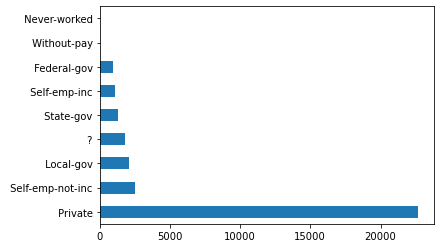

In [15]:
df_raw[' workclass'].value_counts().plot.barh()

In [16]:
raw_x = df_raw.copy()

In [17]:
raw_X_train, raw_X_test = train_test_split(raw_x, test_size=0.2, random_state=43)
raw_X_train, raw_X_val = train_test_split(raw_X_train, test_size=0.2, random_state=42)

In [18]:
raw_X_val.shape

(5210, 15)

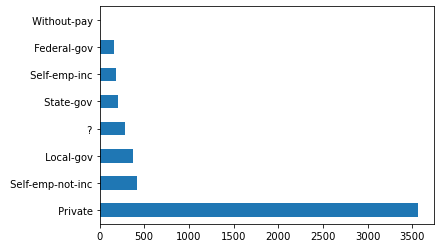

In [19]:
raw_X_val[' workclass'].value_counts().plot.barh()

In [20]:
k = raw_X_val.copy()
k['pred_std'] = np.std(preds, axis=0)
k['pred_mean'] = np.mean(preds, axis=0)

In [21]:
enc_summ = k[[' workclass', ' income', 'pred_mean', 'pred_std']].groupby([' workclass',
                                                                          ' income'], as_index=False).mean()

In [22]:
enc_summ

,workclass,income,pred_mean,pred_std
0,?,<=50K,0.200969,0.148626
1,?,>50K,0.193966,0.139303
2,Federal-gov,<=50K,0.211408,0.145614
3,Federal-gov,>50K,0.273214,0.177187
4,Local-gov,<=50K,0.218216,0.154817
5,Local-gov,>50K,0.215138,0.155338
6,Private,<=50K,0.202822,0.161094
7,Private,>50K,0.215264,0.159644
8,Self-emp-inc,<=50K,0.256686,0.145289
9,Self-emp-inc,>50K,0.217647,0.176538


## 2. Feature Importance

In [23]:
fi = rf_feat_importance(m, X); fi[:10]

,cols,imp
15,marital-status_ Married-civ-spouse,0.262577
3,capital-gain,0.178647
2,education-num,0.172086
0,age,0.082380
1,fnlwgt,0.063470
5,hours-per-week,0.048537
4,capital-loss,0.043701
17,marital-status_ Never-married,0.038490
23,occupation_ Exec-managerial,0.019210
29,occupation_ Prof-specialty,0.010924


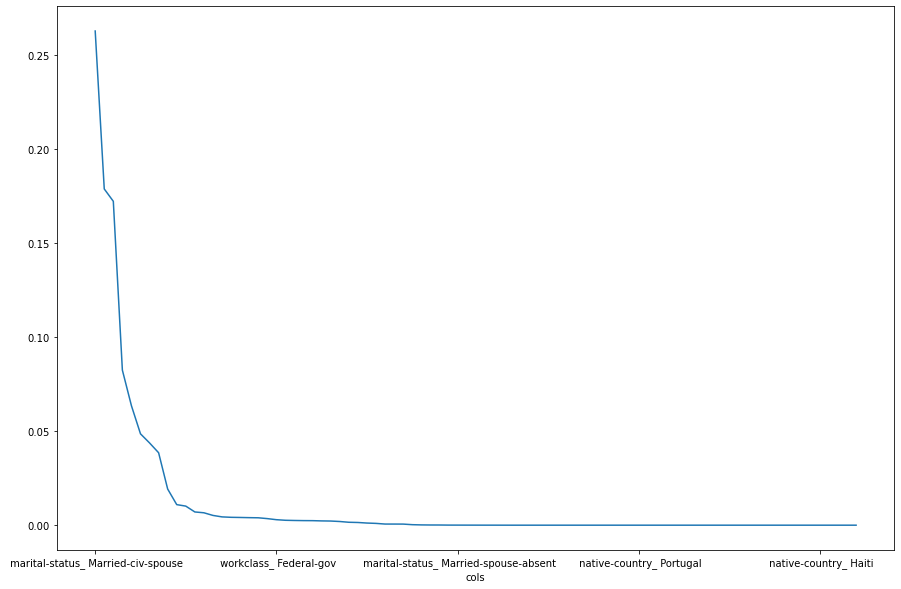

In [24]:
fi.plot('cols', 'imp', figsize=(15,10), legend=False)

In [25]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

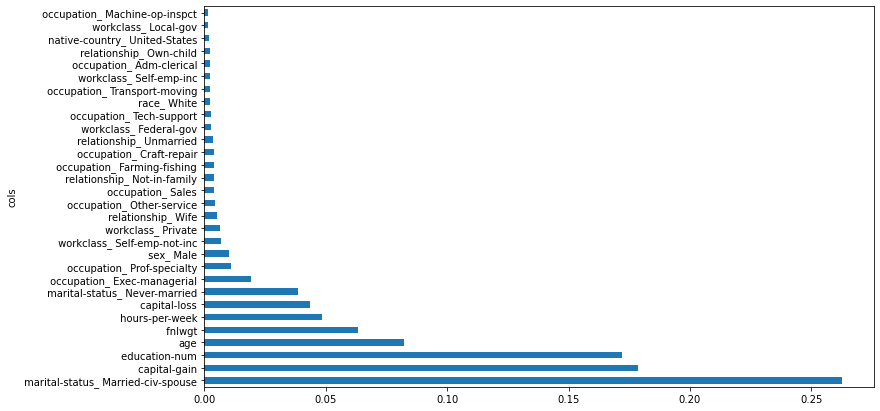

In [26]:
plot_fi(fi[:30])

In [33]:
to_keep = fi[fi.imp>0.003]
len(to_keep)

20

In [35]:
df_keep = X[to_keep.cols].copy()

In [36]:
df_keep

,marital-status_ Married-civ-spouse,capital-gain,education-num,age,fnlwgt,hours-per-week,capital-loss,marital-status_ Never-married,occupation_ Exec-managerial,occupation_ Prof-specialty,sex_ Male,workclass_ Self-emp-not-inc,workclass_ Private,relationship_ Wife,occupation_ Other-service,occupation_ Sales,relationship_ Not-in-family,occupation_ Farming-fishing,occupation_ Craft-repair,relationship_ Unmarried
0,0,2174,13,39,77516,40,0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,1,0,13,50,83311,13,0,0,1,0,1,1,0,0,0,0,0,0,0,0
2,0,0,9,38,215646,40,0,0,0,0,1,0,1,0,0,0,1,0,0,0
3,1,0,7,53,234721,40,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,1,0,13,28,338409,40,0,0,0,1,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,1,0,12,27,257302,38,0,0,0,0,0,0,1,1,0,0,0,0,0,0
32557,1,0,9,40,154374,40,0,0,0,0,1,0,1,0,0,0,0,0,0,0
32558,0,0,9,58,151910,40,0,0,0,0,0,0,1,0,0,0,0,0,0,1
32559,0,0,9,22,201490,20,0,1,0,0,1,0,1,0,0,0,0,0,0,0


In [37]:
X_train, X_test = train_test_split(df_keep, test_size=0.2, random_state=44)

In [42]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=44)

In [44]:
X_train.shape

(20838, 20)

In [45]:
set_rf_samples(2000)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train), m.oob_score_, m.score(X_val, y_val))

0.7586140704482196 0.7559746616757846 0.7683301343570058


The model got really worse.. both the interpretation techniques tried so far did not give good results for this classificiation model.. maybe I'm just doing it wrong.

## 3. One hot encoding
This is already done for this particular dataset because there are so many categorical variables. Usually, in case of large/very large datasets, we won't have the luxury of apply one hot encoding to all the variables because it increase the size and computing power needed considerably. So in that case, we use the **max_n_cats** parameter or similar parameter to restrict one hot encoding only to the columns that do not have too many categories and we label encoding the rest of the categorical variables.

## 4. Removing Redundant Features

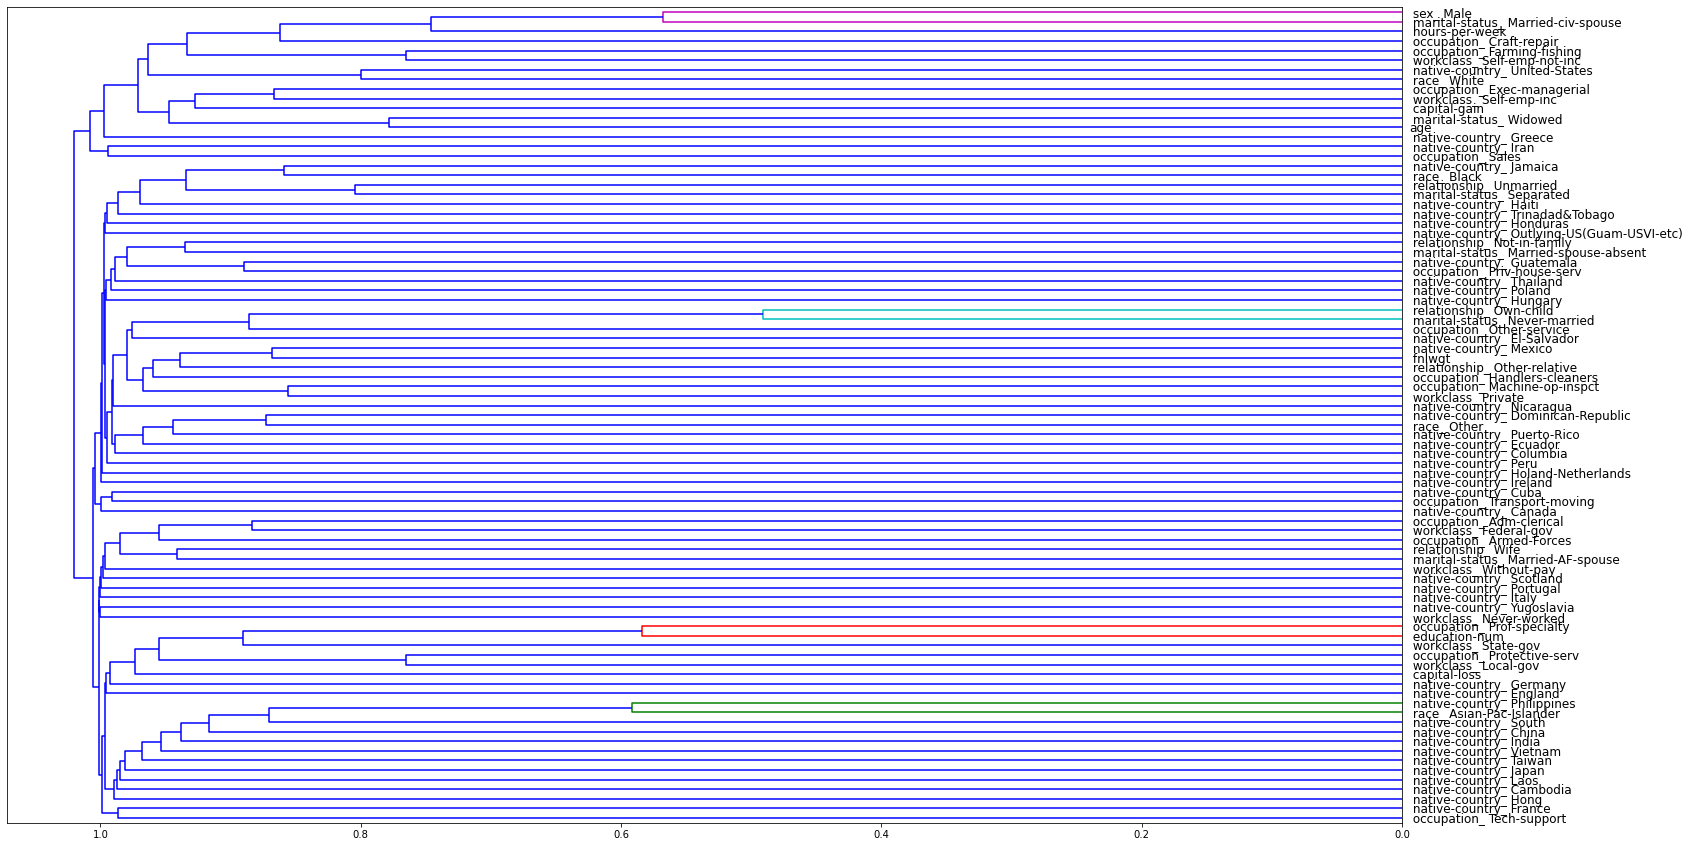

In [26]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(25,15))
dendrogram = hc.dendrogram(z, labels=X.columns, orientation='left', leaf_font_size=12)
plt.show()